In [1]:
import pandas as pd
import time
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from statsmodels.api import add_constant
import statsmodels.api as sm

## Import Data

The data that is imported is already cleaned in another file

In [2]:
google_df_import = pd.read_csv("../cleaned.csv",encoding='cp1252')
#google_df_import = google_df_import.sample(n=1000, random_state=1) #uncomment to run on sample

In [3]:
google_df = google_df_import.copy()

## Preliminary analysis

based on: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/ 

### Statistics on variables

Counts and distribution of 3 main variables of interest.

In [6]:
print('Total number of apps = ' + str(len(google_df)))
print(str(len(google_df[google_df.free_app == 1])) + ' free apps, ' + str(len(google_df[google_df.free_app == 0])) + ' paid apps.' + 
      '(' + str(round(len(google_df[google_df.free_app == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.free_app == 0]) / len(google_df) * 100, 1)) + '%)')
print(str(len(google_df[google_df.has_ads == 1])) + ' apps with advertisements, ' + str(len(google_df[google_df.has_ads == 0])) + ' apps without ads.' + 
      '(' + str(round(len(google_df[google_df.has_ads == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.has_ads == 0]) / len(google_df) * 100, 1)) + '%)')
print(str(len(google_df[google_df.in_app == 1])) + ' apps with in-app purchases, ' + str(len(google_df[google_df.in_app == 0])) + ' apps without in-app purchases.' + 
     '(' + str(round(len(google_df[google_df.in_app == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.in_app == 0]) / len(google_df) * 100, 1)) + '%)')

Total number of apps = 1000
920 free apps, 80 paid apps.(92.0%, 8.0%)
548 apps with advertisements, 452 apps without ads.(54.8%, 45.2%)
136 apps with in-app purchases, 864 apps without in-app purchases.(13.6%, 86.4%)


In [9]:
#Total apps that have a 5 star rating
len(google_df[google_df.rating_app == 5])

116

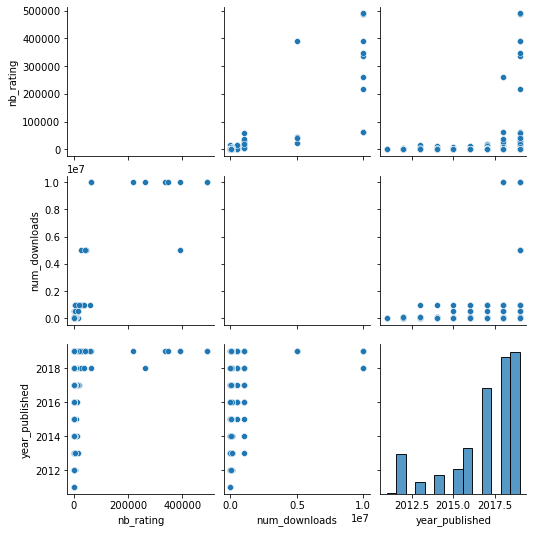

In [10]:
def multiple_displot(data, features):
    sns.pairplot(data[features])
    
features = ['nb_rating', 'num_downloads', 'year_published', 'version']
multiple_displot(google_df, features)

### Correlations between all variables (correlation)

In [11]:
def multicollinearity_assumption(google_data):

    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    corr_matrix = google_data.corr()
    print(corr_matrix)
    sns.heatmap(corr_matrix, annot=True)
    plt.title('Correlation of Variables')
    plt.show()

                        rating_app  nb_rating  num_downloads   has_ads  \
rating_app                1.000000   0.042638       0.026679  0.010215   
nb_rating                 0.042638   1.000000       0.851867  0.042082   
num_downloads             0.026679   0.851867       1.000000  0.069284   
has_ads                   0.010215   0.042082       0.069284  1.000000   
in_app                   -0.022403   0.132566       0.153455  0.178614   
...                            ...        ...            ...       ...   
TravelANDLocal           -0.019429  -0.024575      -0.032870 -0.074921   
Trivia                   -0.021855  -0.009642      -0.013263  0.013894   
VideoPlayersANDEditors   -0.067798  -0.005405      -0.007293 -0.029082   
Weather                  -0.013162  -0.010318      -0.015361  0.026277   
Word                      0.035872  -0.000457      -0.011478  0.062484   

                          in_app  nb_screenshots  year_published       age  \
rating_app             -0.022403 

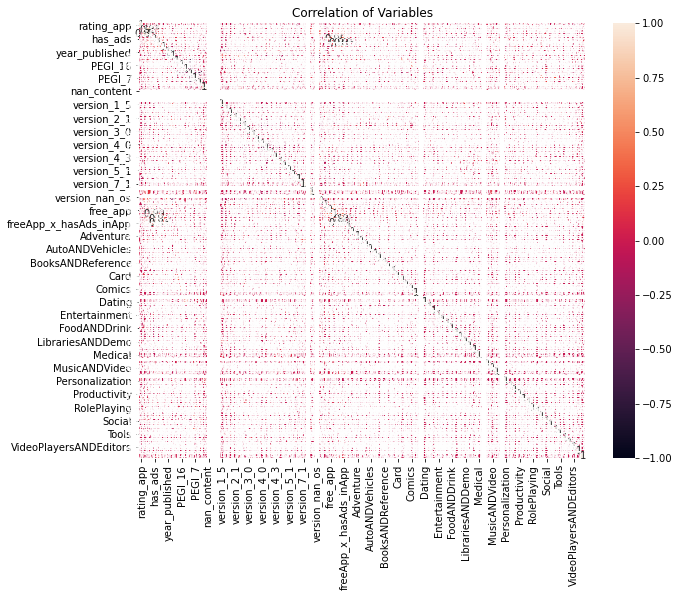

In [12]:
multicollinearity_assumption(google_df)

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def multicollinearity_VIF(google_data):
    X = google_data.copy()

    #convert booleans to integers because the model cannot handle booleans (one hot)
    X['has_ads'] = X['has_ads']*1
    X['in_app'] = X['in_app']*1
    X['free_app'] = X['free_app']*1
    X['freeApp_x_hasAds'] = X['freeApp_x_hasAds']*1
    X['freeApp_x_inApp'] = X['freeApp_x_inApp']*1
    X['freeApp_x_hasAds_inApp'] = X['freeApp_x_hasAds_inApp']*1

    X = X.drop(columns=['my_app_id', 'price_gplay', 'num_downloads_cat', 'more_from_developer', 'permissions', 'version']) #drop object columns (dropped columns are irrelevant for VIF)
    X = X.drop(columns=['freeApp_x_hasAds', 'freeApp_x_inApp', 'freeApp_x_hasAds_inApp']) #remove interaction effects becasue the cause high VIF scores
    VIFs = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
    print(VIFs)
    
#no high VIF scores (except for the interaction effects which is to be expected)

In [14]:
multicollinearity_VIF(google_df)

c:\users\s162668\appdata\local\programs\python\python38\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\s162668\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


rating_app                1.125129
nb_rating                 4.000891
num_downloads             4.137402
has_ads                   1.659493
in_app                    1.256849
                            ...   
TravelANDLocal                 inf
Trivia                         inf
VideoPlayersANDEditors         inf
Weather                        inf
Word                           inf
Length: 96, dtype: float64


### Autocorrelation assumption

In [15]:
def autocorrelation_assumption(google_df):

    from statsmodels.stats.stattools import durbin_watson
   
    # Calculating residuals for the Durbin Watson-tests
    result = sm.ols(formula="rating_app ~ free_app + has_ads + in_app + nb_rating + freeApp_x_hasAds + num_downloads + freeApp_x_inApp  + freeApp_x_hasAds_inApp", data=google_df).fit()

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(result.resid)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [16]:
autocorrelation_assumption(google_df)

AttributeError: module 'statsmodels.api' has no attribute 'ols'

### Normal distribution of all variables

In [ ]:
def check_normal_dist(data, target):
    #visualize the distribution
    sns.displot(data, x=str(target), bins = len(data[target].value_counts()))
    #visualize the same distribution, also showing the division in free and paid apps
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="free_app", multiple="stack")
    
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="in_app", multiple="stack")
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="has_ads", multiple="stack")

    # Perform and evaluate three normality tests: Shapiro-Swilk, D’Agostino’s K^2, and Anderson-Darling Test. 
    print('Shapiro-Swilk test:')
    stat, p = stats.shapiro(data[target])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print('-------------------------------------------')
        
    print('D’Agostino’s K^2 Test')
    stat, p = stats.normaltest(data[target])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print('-------------------------------------------')
    
    print('Anderson-Darling Test:')
    result = stats.anderson(data[target])
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
    print('-------------------------------------------')
    
check_normal_dist(google_df, 'rating_app')

In [ ]:
def normalize_data(data, feature):
    transform = google_df[['rating_app', 'nb_rating']].copy()
    transform = transform.loc[transform.nb_rating > 5]

    transform['box-cox'],_ = stats.boxcox(transform['rating_app'])
    transform['yeojohnson'],_ = stats.yeojohnson(transform['rating_app'])
    check_normal_dist(transform, 'box-cox')
    check_normal_dist(transform, 'yeojohnson')


#     return transform

normalize_data(google_df, 'rating_app')

In [4]:
def normalise_function(feature):
    x = google_df[[feature]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled)
    google_df[feature + '_normalized'] = df_normalized

#sns.displot(google_df, x=google_df['nb_apps_developer'], bins =10)
normalise_function('nb_apps_developer')
normalise_function('age')
normalise_function('nb_rating')
normalise_function('nb_screenshots')
normalise_function('nb_permissions')

In [5]:
#We moeten nog kijken naar hoe we de nans niet weg hoeven te halen
continious_variables = ['nb_rating_normalized', 'nb_apps_developer_normalized', 'age_normalized', 'nb_screenshots_normalized', 'nb_permissions_normalized']
test = google_df.dropna(subset = continious_variables, inplace=True)
print([google_df[i].isnull().values.any() for i in continious_variables])

[False, False, False, False, False]


In [ ]:
google_df['nb_apps_developer'].value_counts()

In [ ]:
check_normal_dist(google_df.loc[google_df.nb_rating > 5], 'rating_app')

### Check linearity of variables

In [18]:
def linear_assumption(google_df):


    result = sm.ols(formula="rating_app ~ free_app + has_ads + in_app + nb_rating + freeApp_x_hasAds + num_downloads + freeApp_x_inApp  + freeApp_x_hasAds_inApp", data=google_df).fit()
    

    google_df_new = pd.DataFrame(columns=['y_pred', 'y_true'])
    google_df_new['y_pred'] = result.predict()
    google_df_new['y_true'] = google_df.rating_app
    print(google_df_new)
    google_df_new = google_df_new.dropna()

    # Plotting the actual vs predicted values
    sns.lmplot(x = 'y_pred', y = 'y_true',  data = google_df_new)
    plt.title('Actual vs. Predicted')
    plt.ylim(0, 5)
    plt.xlim(0, 5)
    plt.show()

### Homoscedasticity assumptions

In [27]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def check_homoscedasticity(target, features, model):
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, target)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show() 

features = []
used_model = ''
check_homoscedasticity(google_df['rating_app'], features, used_model)

AttributeError: 'ellipsis' object has no attribute 'predict'

In [18]:
google_df['log'] = (np.log(google_df['rating_app'])) #0.027 instead of 0.033
google_df['boxcox'],_ = stats.boxcox(google_df['rating_app']) #0.039 instead of 0.033
google_df['yeojohnson'],_ = stats.yeojohnson(google_df['rating_app']) #0.039 instead of 0.033

#### Add new variables to check hypothesis

In [7]:
google_df['ads&purchases'] = google_df.has_ads & google_df.in_app
empty_list = []
for idx in range(len(google_df.free_app)):
    if google_df.free_app[idx] & google_df.has_ads[idx]:
        empty_list.append('free_and_ads')
    elif google_df.free_app[idx] and not google_df.has_ads[idx]:
        empty_list.append('free_no_ads')
    elif google_df.has_ads[idx] and not google_df.free_app[idx]:
        empty_list.append('paid_and_ads')
    elif not (google_df.free_app[idx] & google_df.has_ads[idx]):
        empty_list.append('paid_no_ads')

google_df['freeXads'] = empty_list

empty_list_1 = []
for idx in range(len(google_df.free_app)):
    if google_df.free_app[idx] & google_df.in_app[idx]:
        empty_list_1.append('free_and_purchases')
    elif google_df.free_app[idx] and not google_df.in_app[idx]:
        empty_list_1.append('free_no_purchases')
    elif google_df.in_app[idx] and not google_df.free_app[idx]:
        empty_list_1.append('paid_and_purchases')
    elif not (google_df.free_app[idx] & google_df.in_app[idx]):
        empty_list_1.append('paid_no_purchases')

google_df['freeXpurchases'] = empty_list_1

empty_list_2 = []
for idx in range(len(google_df.free_app)):
    if google_df.free_app[idx] & google_df['ads&purchases'][idx]:
        empty_list_2.append('free_and_purchases_and_ads')
    elif google_df.free_app[idx] and not google_df['ads&purchases'][idx]:
        empty_list_2.append('free_no_purchases_no_ads')
    elif google_df['ads&purchases'][idx] and not google_df.free_app[idx]:
        empty_list_2.append('paid_and_purchases_and_ads')
    elif not (google_df.free_app[idx] & google_df['ads&purchases'][idx]):
        empty_list_2.append('paid_no_purchases_no_ads')

google_df['freeXpurchasesANDads'] = empty_list_2

google_df["freeXads"] = google_df["freeXads"].cat.codes
google_df["freeXpurchases"] = google_df["freeXpurchases"].cat.codes
google_df["freeXpurchasesANDads"] = google_df["freeXpurchasesANDads"].cat.codes

KeyError: 126801

# Analysis

### OLS

Now the OLS is done 4 times, once for each hypothesis. Consequently, the first OLS only uses free_app as indepedent variable.
The second OLS also includes whether an app uses in-app advertisements
The thrid OLS also includes whether an app uses in-app purchases
The fourth OLS also includes whether an app uses both in-app purchases and in-app advertisements.

#### Hypothesis 1

In [128]:
y = google_df.rating_app
X = google_df[['free_app','nb_rating_normalized','nb_apps_developer_normalized','age_normalized','PEGI_12', 'PEGI_16', 'PEGI_18', 'PEGI_3', 'PEGI_7', 
               'Parenta', 'Unrated', 'Parenting','version_1_0', 'version_1_1',
               'version_1_5', 'version_1_6', 'version_2_0', 'version_2_1', 'version_2_2', 'version_2_3', 'version_3_0', 'version_3_1',
               'version_3_2', 'version_4_0', 'version_4_1', 'version_4_2', 'version_4_3', 'version_4_4', 'version_5_0', 'version_5_1',
               'version_6_0', 'version_7_0', 'version_7_1', 'version_8_0', 'version_Var', 'Action', 'ActionANDAdventure', 'Adventure', 'Arcade',
               'AutoANDVehicles', 'Beauty', 'Board', 'BooksANDReference', 'BrainGames', 'Business', 'Card', 'Casino', 'Casual', 'Comics', 'Communication',
               'Creativity', 'Dating', 'Education', 'Educational', 'Entertainment', 'Events', 'Finance', 'FoodANDDrink', 'HealthANDFitness', 'HouseANDHome',
               'LibrariesANDDemo', 'Lifestyle', 'MapsANDNavigation', 'Medical', 'Music', 'MusicANDAudio', 'MusicANDVideo', 'NewsANDMagazines', 'Parenting', 
               'Personalization', 'Photography', 'PretendPlay', 'Productivity', 'Puzzle', 'Racing', 'RolePlaying', 'Shopping', 'Simulation', 'Social', 'Sports', 'Strategy',
               'Tools', 'TravelANDLocal', 'Trivia', 'VideoPlayersANDEditors', 'Weather', 'Word', 'nb_screenshots_normalized','nb_permissions_normalized']]
X = add_constant(X)

In [129]:
model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     309.9
Date:                Sun, 15 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:32:16   Log-Likelihood:            -8.4340e+05
No. Observations:              775684   AIC:                         1.687e+06
Df Residuals:                  775596   BIC:                         1.688e+06
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Hypothesis 2

In [210]:
google_df.free_app = google_df.free_app.astype('float')
google_df.in_app = google_df.in_app.astype('float')
google_df.has_ads = google_df.has_ads.astype('float')

y = google_df.rating_app
X = google_df[['free_app','has_ads', 'freeXads','nb_rating_normalized','nb_apps_developer_normalized','age_normalized','PEGI_12', 'PEGI_16', 'PEGI_18', 'PEGI_3', 'PEGI_7', 
               'Parenta', 'Unrated', 'Parenting','version_1_0', 'version_1_1',
               'version_1_5', 'version_1_6', 'version_2_0', 'version_2_1', 'version_2_2', 'version_2_3', 'version_3_0', 'version_3_1',
               'version_3_2', 'version_4_0', 'version_4_1', 'version_4_2', 'version_4_3', 'version_4_4', 'version_5_0', 'version_5_1',
               'version_6_0', 'version_7_0', 'version_7_1', 'version_8_0', 'version_Var', 'Action', 'ActionANDAdventure', 'Adventure', 'Arcade',
               'AutoANDVehicles', 'Beauty', 'Board', 'BooksANDReference', 'BrainGames', 'Business', 'Card', 'Casino', 'Casual', 'Comics', 'Communication',
               'Creativity', 'Dating', 'Education', 'Educational', 'Entertainment', 'Events', 'Finance', 'FoodANDDrink', 'HealthANDFitness', 'HouseANDHome',
               'LibrariesANDDemo', 'Lifestyle', 'MapsANDNavigation', 'Medical', 'Music', 'MusicANDAudio', 'MusicANDVideo', 'NewsANDMagazines', 'Parenting', 
               'Personalization', 'Photography', 'PretendPlay', 'Productivity', 'Puzzle', 'Racing', 'RolePlaying', 'Shopping', 'Simulation', 'Social', 'Sports', 'Strategy',
               'Tools', 'TravelANDLocal', 'Trivia', 'VideoPlayersANDEditors', 'Weather', 'Word', 'nb_screenshots_normalized','nb_permissions_normalized']]
X = add_constant(X)

In [211]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     304.4
Date:                Sun, 15 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:09:54   Log-Likelihood:            -8.4333e+05
No. Observations:              775684   AIC:                         1.687e+06
Df Residuals:                  775594   BIC:                         1.688e+06
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Hypothesis 3

In [133]:
y = google_df.rating_app
X = google_df[['free_app','in_app', 'freeXpurchases', 'nb_rating_normalized','nb_apps_developer_normalized','age_normalized','PEGI_12', 'PEGI_16', 'PEGI_18', 'PEGI_3', 'PEGI_7', 
               'Parenta', 'Unrated', 'Parenting','version_1_0', 'version_1_1',
               'version_1_5', 'version_1_6', 'version_2_0', 'version_2_1', 'version_2_2', 'version_2_3', 'version_3_0', 'version_3_1',
               'version_3_2', 'version_4_0', 'version_4_1', 'version_4_2', 'version_4_3', 'version_4_4', 'version_5_0', 'version_5_1',
               'version_6_0', 'version_7_0', 'version_7_1', 'version_8_0', 'version_Var', 'Action', 'ActionANDAdventure', 'Adventure', 'Arcade',
               'AutoANDVehicles', 'Beauty', 'Board', 'BooksANDReference', 'BrainGames', 'Business', 'Card', 'Casino', 'Casual', 'Comics', 'Communication',
               'Creativity', 'Dating', 'Education', 'Educational', 'Entertainment', 'Events', 'Finance', 'FoodANDDrink', 'HealthANDFitness', 'HouseANDHome',
               'LibrariesANDDemo', 'Lifestyle', 'MapsANDNavigation', 'Medical', 'Music', 'MusicANDAudio', 'MusicANDVideo', 'NewsANDMagazines', 'Parenting', 
               'Personalization', 'Photography', 'PretendPlay', 'Productivity', 'Puzzle', 'Racing', 'RolePlaying', 'Shopping', 'Simulation', 'Social', 'Sports', 'Strategy',
               'Tools', 'TravelANDLocal', 'Trivia', 'VideoPlayersANDEditors', 'Weather', 'Word', 'nb_screenshots_normalized','nb_permissions_normalized']]
X = add_constant(X)

In [134]:
model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     307.0
Date:                Sun, 15 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:38:08   Log-Likelihood:            -8.4337e+05
No. Observations:              775684   AIC:                         1.687e+06
Df Residuals:                  775595   BIC:                         1.688e+06
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Hypothesis 4

In [152]:
y = google_df.rating_app
X = google_df[['free_app','ads&purchases', 'freeXpurchasesANDads', 'nb_rating_normalized','nb_apps_developer_normalized','age_normalized','PEGI_12',
               'PEGI_16', 'PEGI_18', 'PEGI_3', 'PEGI_7', 
               'Parenta', 'Unrated', 'Parenting','version_1_0', 'version_1_1',
               'version_1_5', 'version_1_6', 'version_2_0', 'version_2_1', 'version_2_2', 'version_2_3', 'version_3_0', 'version_3_1',
               'version_3_2', 'version_4_0', 'version_4_1', 'version_4_2', 'version_4_3', 'version_4_4', 'version_5_0', 'version_5_1',
               'version_6_0', 'version_7_0', 'version_7_1', 'version_8_0', 'version_Var', 'Action', 'ActionANDAdventure', 'Adventure', 'Arcade',
               'AutoANDVehicles', 'Beauty', 'Board', 'BooksANDReference', 'BrainGames', 'Business', 'Card', 'Casino', 'Casual', 'Comics', 'Communication',
               'Creativity', 'Dating', 'Education', 'Educational', 'Entertainment', 'Events', 'Finance', 'FoodANDDrink', 'HealthANDFitness', 'HouseANDHome',
               'LibrariesANDDemo', 'Lifestyle', 'MapsANDNavigation', 'Medical', 'Music', 'MusicANDAudio', 'MusicANDVideo', 'NewsANDMagazines', 'Parenting', 
               'Personalization', 'Photography', 'PretendPlay', 'Productivity', 'Puzzle', 'Racing', 'RolePlaying', 'Shopping', 'Simulation', 'Social', 'Sports', 'Strategy',
               'Tools', 'TravelANDLocal', 'Trivia', 'VideoPlayersANDEditors', 'Weather', 'Word', 'nb_screenshots_normalized','nb_permissions_normalized']]
X = add_constant(X)

In [153]:
model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     307.2
Date:                Sun, 15 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:57:57   Log-Likelihood:            -8.4336e+05
No. Observations:              775684   AIC:                         1.687e+06
Df Residuals:                  775595   BIC:                         1.688e+06
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Poisson

Poisson is tried as an alternative for the normal OLS. The rating is transformed to a rounded variable, so only containing the values 1, 2, 3, 4 and 5. This Poisson is only runned once in this notebook (with all control variables and independent variables) since this model is considered less usefull than the OLS.

In [ ]:
#Make a count variable from rating so poisson can be used.
google_df['rating_app_rounded'] = google_df.rating_app.apply(lambda x: round(x))

In [31]:
y = google_df.rating_app_rounded
X = google_df[['free_app',  'PEGI_12', 'PEGI_16', 'PEGI_18', 'PEGI_3', 'PEGI_7', 'Parenta', 'Unrated', 'version_1_0', 'version_1_1',
               'version_1_5', 'version_1_6', 'version_2_0', 'version_2_1', 'version_2_2', 'version_2_3', 'version_3_0', 'version_3_1',
               'version_3_2', 'version_4_0', 'version_4_1', 'version_4_2', 'version_4_3', 'version_4_4', 'version_5_0', 'version_5_1',
               'version_6_0', 'version_7_0', 'version_7_1', 'version_8_0', 'version_Var', 'Action', 'ActionANDAdventure', 'Adventure', 'Arcade',
               'AutoANDVehicles', 'Beauty', 'Board', 'BooksANDReference', 'BrainGames', 'Business', 'Card', 'Casino', 'Casual', 'Comics', 'Communication',
               'Creativity', 'Dating', 'Education', 'Educational', 'Entertainment', 'Events', 'Finance', 'FoodANDDrink', 'HealthANDFitness', 'HouseANDHome',
               'LibrariesANDDemo', 'Lifestyle', 'MapsANDNavigation', 'Medical', 'Music', 'MusicANDAudio', 'MusicANDVideo', 'NewsANDMagazines', 'Parenting', 
               'Personalization', 'Photography', 'PretendPlay', 'Productivity', 'Puzzle', 'Racing', 'RolePlaying', 'Shopping', 'Simulation', 'Social', 'Sports', 
               'Strategy', 'Tools', 'TravelANDLocal', 'Trivia', 'VideoPlayersANDEditors', 'Weather', 'Word',]]
X = add_constant(X)

In [32]:
res = sm.GLM(y.astype(float), X.astype(float),family = sm.families.Poisson()).fit()
print(res.summary())

#Chisqaured: 1.11e+05 > 107.52 so the 0 hypothesis is rejected

ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

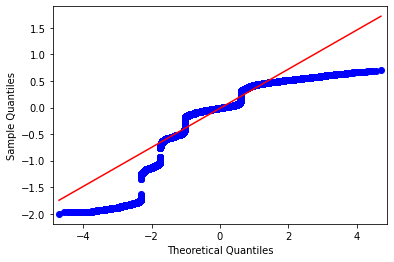

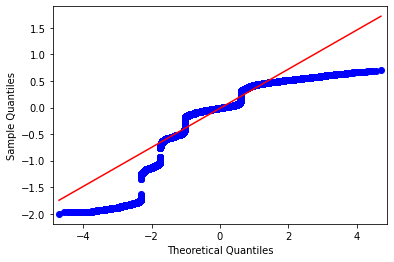

In [38]:
from statsmodels.graphics.api import abline_plot
from statsmodels import graphics

resid = res.resid_deviance.copy()
graphics.gofplots.qqplot(resid, line='r')

### Negative Binomial

In [34]:
res = sm.OLS(y.astype(float), X.astype(float),family = sm.genmod.families.family.NegativeBinomial).fit()
print(res.summary())

#Chisqaured: 1.11e+05 > 107.52 so the 0 hypothesis is rejected

MemoryError: Unable to allocate 485. MiB for an array with shape (63606088,) and data type float64